# Linear Regression with Predictions and Demographics
*Shaurya Gaur*

Are the predictions from our models correlated with certain variables that they should (not) be?

Adapted from [this lab exercise](https://github.com/Harshita0109/Sales-Prediction/blob/master/2048035_Lab3.ipynb).

In [52]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr, spearmanr

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "/mnt/c/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results/nlst"
# NLST_PREDS = TEAMS_DIR ## Comment out if not using Teams backup (aka Chansey is up :)

In [45]:
def calc_corr(df0, demo_col, models):
    allstats = []
    df = df0.dropna(subset=demo_col, axis=0)
    for m in models:
        predcol = df[models[m]]
        
        pearson_result = pearsonr(df[demo_col], predcol)
        pearson_lo, pearson_hi = pearson_result.confidence_interval(0.95)

        spearman_result = spearmanr(df[demo_col], predcol)
        
        slr = LinearRegression()
        slr.fit(np.array(df[demo_col].tolist()).reshape(-1, 1), predcol)

        allstats.append({
            'SRC': spearman_result.statistic,
            'SRC p-val': spearman_result.pvalue,
            'PCC': pearson_result.statistic,
            'PCC p-val': pearson_result.pvalue,
            'PCC CI-lo': pearson_lo,
            'PCC CI-hi': pearson_hi,
            'SLR intercept': slr.intercept_,
            'SLR coefficient': slr.coef_[0], 
        })
    statdf = pd.DataFrame(allstats, index=models.keys())
    return statdf

## NLST: Load data

In [46]:
nlst_preds = pd.read_csv(f"{NLST_PREDS}/nlst_demov1_allmodels.csv")
nlst_preds = utils.prep_nlst_preds(nlst_preds, scanlevel=True, sybil=True, tijmen=True)
nlst_preds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1172 entries, 4740 to 10150
Data columns (total 92 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PatientID              1172 non-null   int64  
 1   StudyDate              1172 non-null   int64  
 2   SeriesInstanceUID      1172 non-null   object 
 3   LesionID               1172 non-null   int64  
 4   Spiculation            1172 non-null   bool   
 5   Diameter [mm]          1172 non-null   float64
 6   Age                    1172 non-null   int64  
 7   Gender                 1172 non-null   int64  
 8   FamilyHistoryLungCa    1172 non-null   bool   
 9   Emphysema              1172 non-null   bool   
 10  NoduleInUpperLung      1172 non-null   bool   
 11  NoduleCounts           1172 non-null   int64  
 12  SCT_EPI_LOC            1119 non-null   float64
 13  xie_gc_gclobe150       53 non-null     float64
 14  loclup                 127 non-null    float64
 15  locru

In [47]:
nlst_preds.isna().sum()

PatientID            0
StudyDate            0
SeriesInstanceUID    0
LesionID             0
Spiculation          0
                    ..
sybil_year2          0
sybil_year3          0
sybil_year4          0
sybil_year5          0
sybil_year6          0
Length: 92, dtype: int64

In [48]:
with open(f'{NLST_PREDS}/nlst_demo_v1_cols.json') as json_data:
    nlst_democols = json.load(json_data)
    json_data.close()

In [49]:
nlst_democols['num']

{'demo': ['height', 'weight', 'Age'],
 'smoke': ['pkyr', 'smokeage', 'smokeday', 'smokeyr']}

In [50]:
MODEL_TO_COL = {
    "Venkadesh": "DL",
    "de Haas Combined": "Thijmen_mean",
    # "de Haas Local": "Thijmen_local",
    # "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (shown nodule)": "Thijmen_global_show",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

## NLST: How are numerical demographic columns related with predictions?

### Demographic columns

height: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.028435,3.307402e-01,-0.030544,0.296115,-0.087653,0.026764,0.415449,-0.002699
de Haas Combined,-0.058854,4.396345e-02,-0.014780,0.613221,-0.071981,0.042518,0.301434,-0.001195
de Haas Global (shown nodule),-0.043830,1.337166e-01,-0.012722,0.663509,-0.069933,0.044573,0.275324,-0.001110
Sybil,0.035494,2.246709e-01,-0.038342,0.189616,-0.095395,0.018961,0.097409,-0.000893
PanCan2b,-0.165170,1.288578e-08,-0.103494,0.000387,-0.159808,-0.046507,0.267843,-0.002885


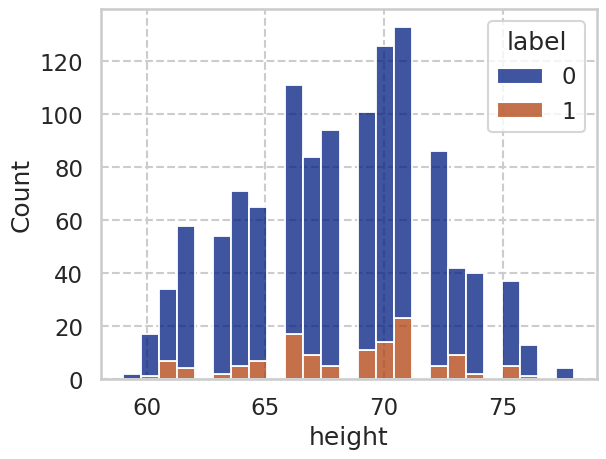

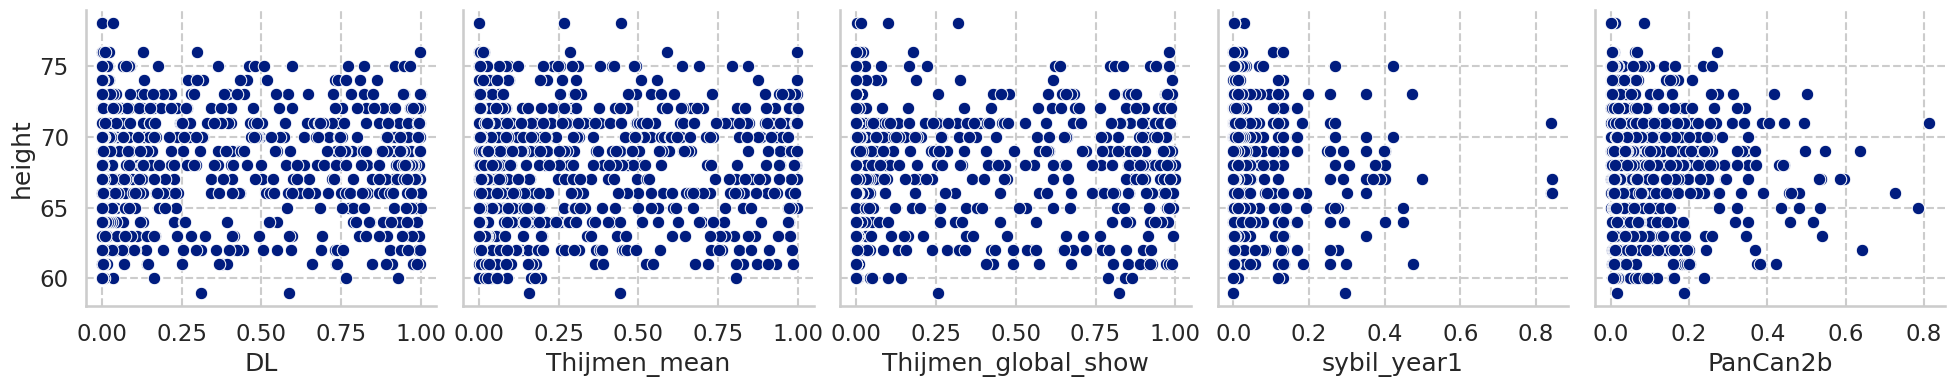

weight: 1 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.116296,6.637757e-05,-0.094037,0.001275,-0.150512,-0.036949,0.378602,-0.000808
de Haas Combined,-0.103823,3.727816e-04,-0.076484,0.008837,-0.133187,-0.019282,0.329218,-0.000601
de Haas Global (shown nodule),-0.141578,1.149582e-06,-0.097604,0.000825,-0.154029,-0.040545,0.350163,-0.000827
Sybil,-0.031750,2.776641e-01,-0.045600,0.118860,-0.102618,0.011717,0.055096,-0.000103
PanCan2b,-0.182877,2.889728e-10,-0.130786,0.000007,-0.186673,-0.074054,0.135915,-0.000354


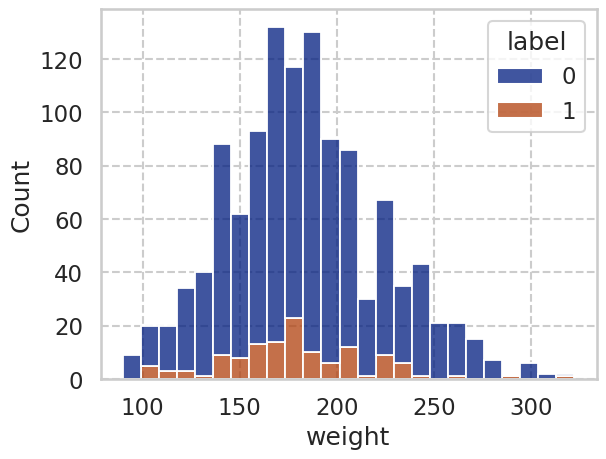

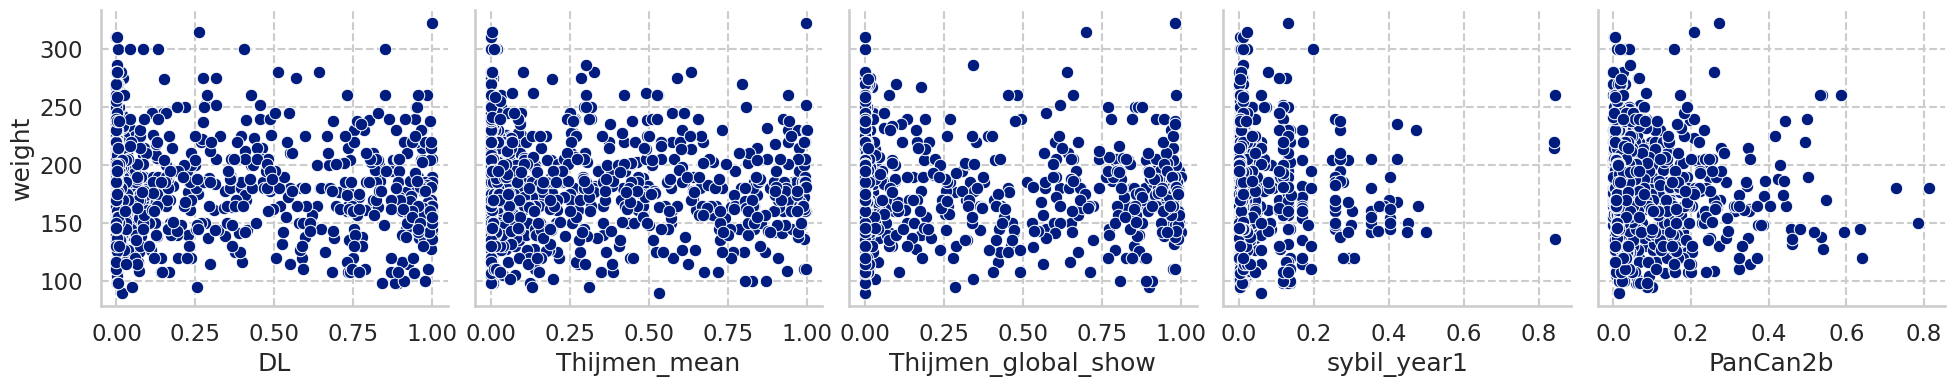

Age: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.108196,2.064553e-04,0.116274,0.000066,0.059408,0.172388,-0.234125,0.007357
de Haas Combined,0.021557,4.609553e-01,0.065453,0.025041,0.008222,0.122257,-0.019830,0.003789
de Haas Global (shown nodule),-0.004375,8.810556e-01,0.011256,0.700279,-0.046036,0.068474,0.155207,0.000703
Sybil,0.172831,2.595219e-09,0.062665,0.031943,0.005423,0.119498,-0.029561,0.001045
PanCan2b,0.147795,3.730462e-07,0.099292,0.000664,0.042270,0.155669,-0.054159,0.001982


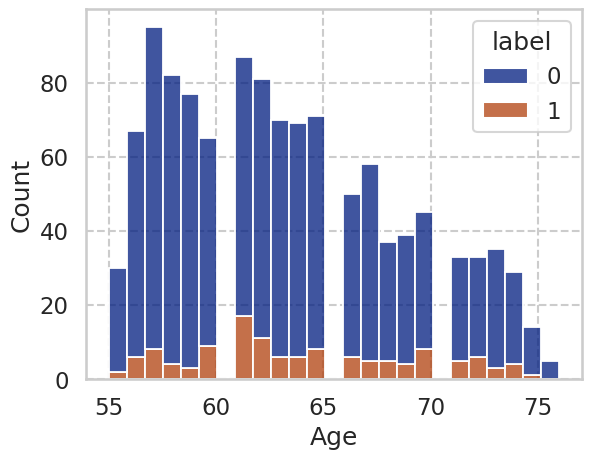

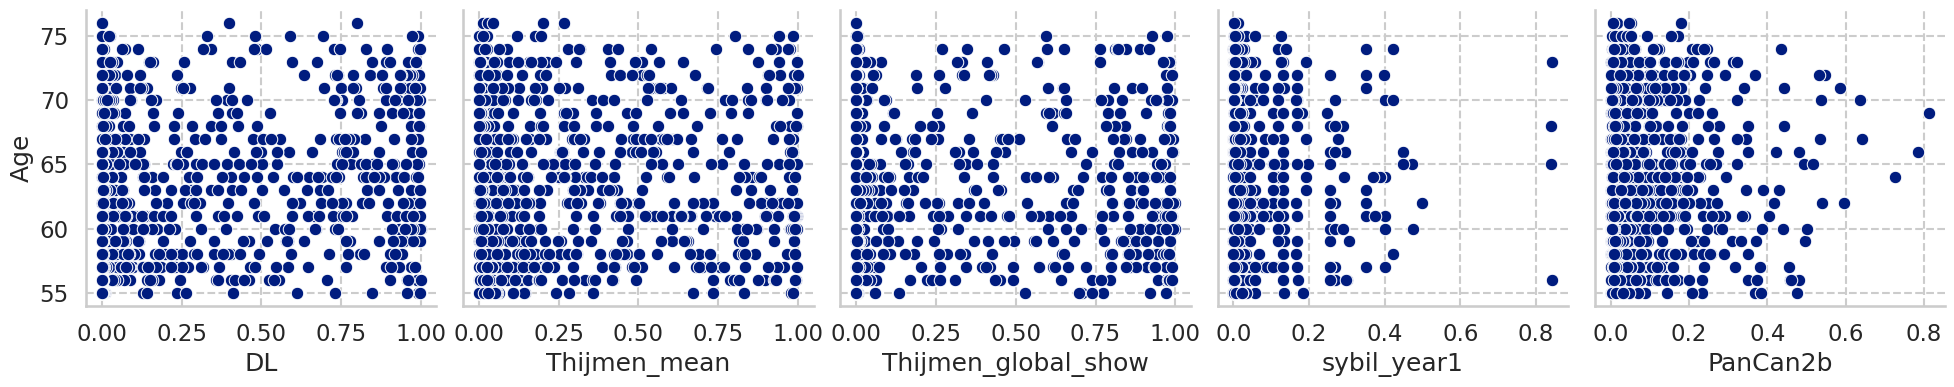

In [54]:
for c in nlst_democols['num']['demo']:
    print(f"{c}: {nlst_preds[c].isna().sum()} null values")
    display(calc_corr(nlst_preds, c, MODEL_TO_COL))
    sns.histplot(nlst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(nlst_preds, x_vars=MODEL_TO_COL.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()

In [55]:
mlr = LinearRegression()
mlr_df = nlst_preds.dropna(subset=nlst_democols['num']['demo'], axis=0)
coefs = {}

for m in MODEL_TO_COL:
    mlr.fit(mlr_df[nlst_democols['num']['demo']], mlr_df[MODEL_TO_COL[m]])
    coefs[m] = mlr.coef_

pd.DataFrame(coefs, index=nlst_democols['num']['demo']).T

,height,weight,Age
Venkadesh,0.003067,-0.000980,0.007108
de Haas Combined,0.003638,-0.000810,0.003521
de Haas Global (shown nodule),0.006123,-0.001183,0.000341
Sybil,-0.000488,-0.000073,0.000970
PanCan2b,-0.001227,-0.000281,0.001948


### Demographic columns (categorical)

marital: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.031450,0.282021,0.013402,0.646699,-0.043893,0.070610,0.221427,0.003870
de Haas Combined,0.075934,0.009308,0.026512,0.364503,-0.030797,0.083647,0.201709,0.007004
de Haas Global (shown nodule),0.001534,0.958172,0.012383,0.671944,-0.044911,0.069595,0.190486,0.003530
Sybil,0.034503,0.237890,-0.016586,0.570535,-0.073778,0.040714,0.039870,-0.001262
PanCan2b,0.070019,0.016509,0.043762,0.134322,-0.013534,0.100771,0.060863,0.003986


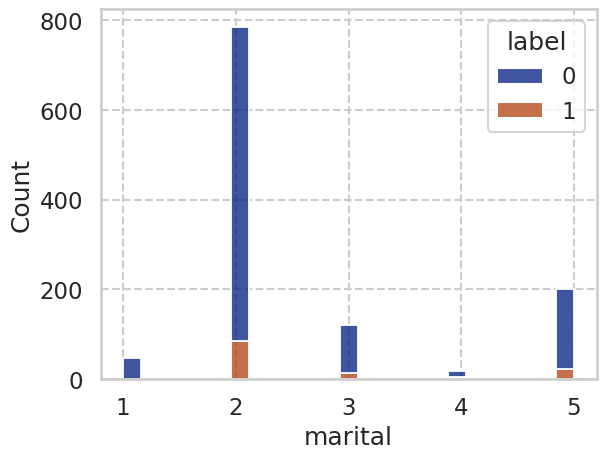

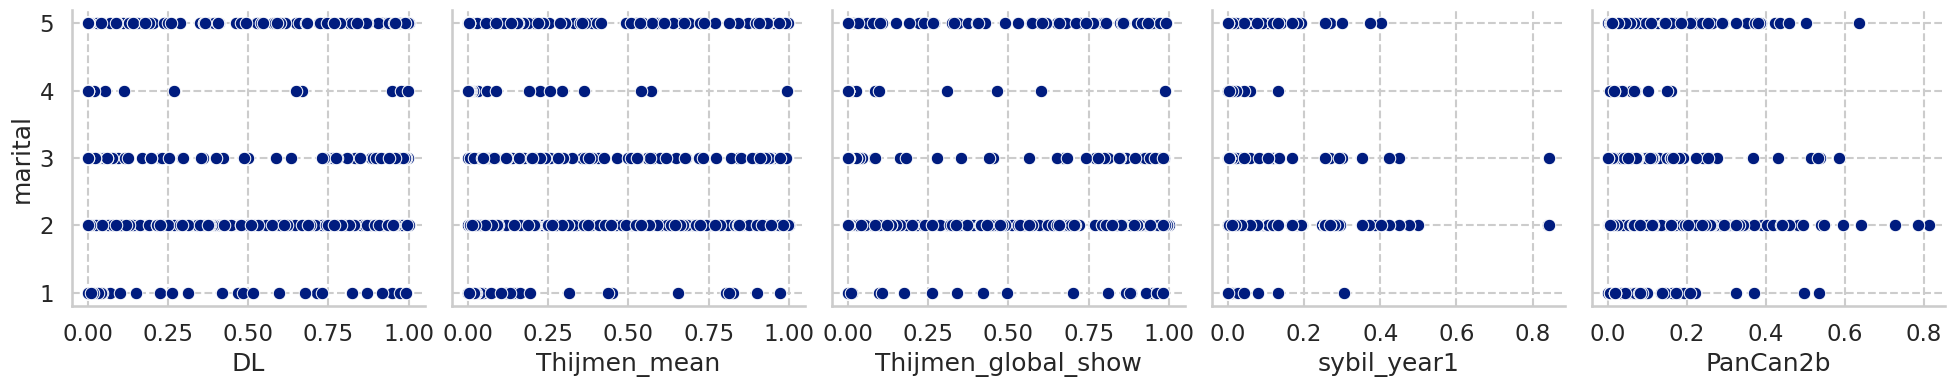

educat: 19 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.082055,0.005305,-0.063460,0.031189,-0.120749,-0.005749,0.290746,-0.013208
de Haas Combined,-0.045667,0.121195,-0.040222,0.172298,-0.097727,0.017550,0.254997,-0.007679
de Haas Global (shown nodule),-0.038814,0.187826,-0.079478,0.006932,-0.136583,-0.021846,0.272596,-0.016261
Sybil,-0.081190,0.005808,-0.029133,0.322969,-0.086719,0.028647,0.043659,-0.001595
PanCan2b,-0.051020,0.083330,-0.021971,0.456069,-0.079602,0.035806,0.077225,-0.001440


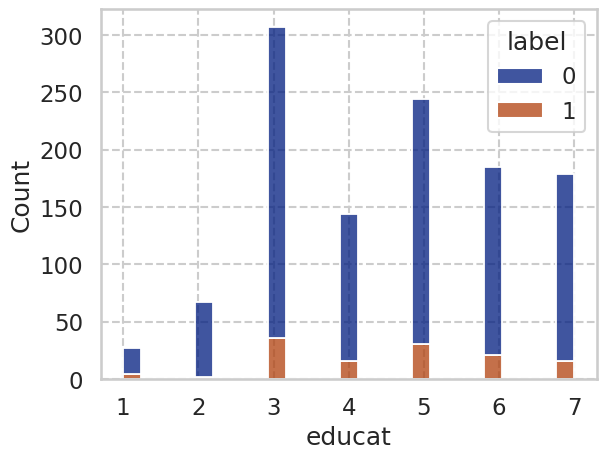

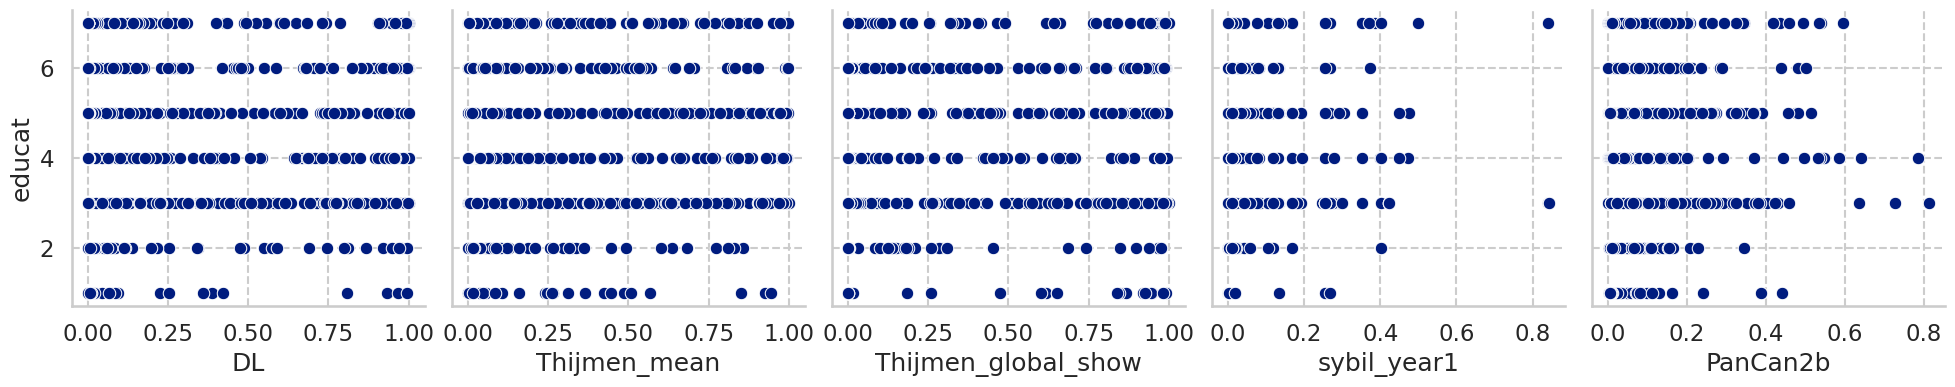

race: 3 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.111494,0.000134,0.093966,0.001298,0.036829,0.150490,0.174729,0.050810
de Haas Combined,0.060063,0.040049,0.035865,0.220451,-0.021515,0.093009,0.200117,0.017751
de Haas Global (shown nodule),0.040270,0.168836,0.010592,0.717527,-0.046772,0.067886,0.192255,0.005640
Sybil,0.070950,0.015254,0.056603,0.053017,-0.000734,0.113570,0.027544,0.008069
PanCan2b,0.125678,0.000016,0.084968,0.003646,0.027768,0.141613,0.054921,0.014500


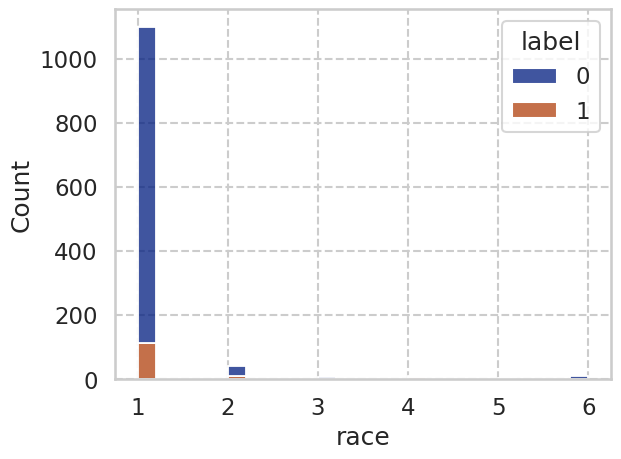

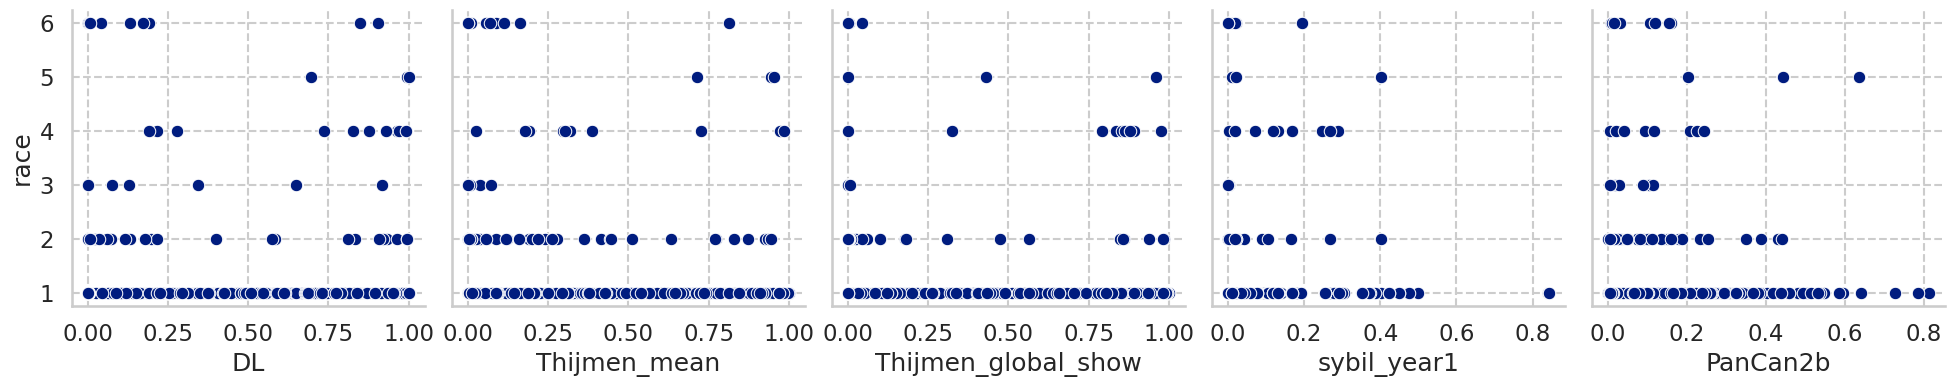

ethnic: 2 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.030483,0.297499,-0.029966,0.305781,-0.087127,0.027392,0.440658,-0.105360
de Haas Combined,-0.045168,0.122563,-0.000940,0.974375,-0.058248,0.056374,0.225973,-0.003027
de Haas Global (shown nodule),-0.080305,0.005989,-0.084791,0.003703,-0.141415,-0.027615,0.784402,-0.293979
Sybil,-0.010989,0.707287,0.002389,0.934936,-0.054929,0.059692,0.032204,0.002217
PanCan2b,-0.042178,0.149352,-0.020611,0.481236,-0.077830,0.036743,0.116283,-0.022780


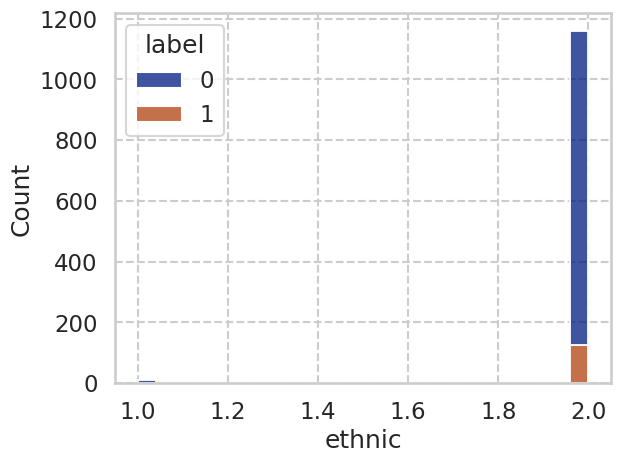

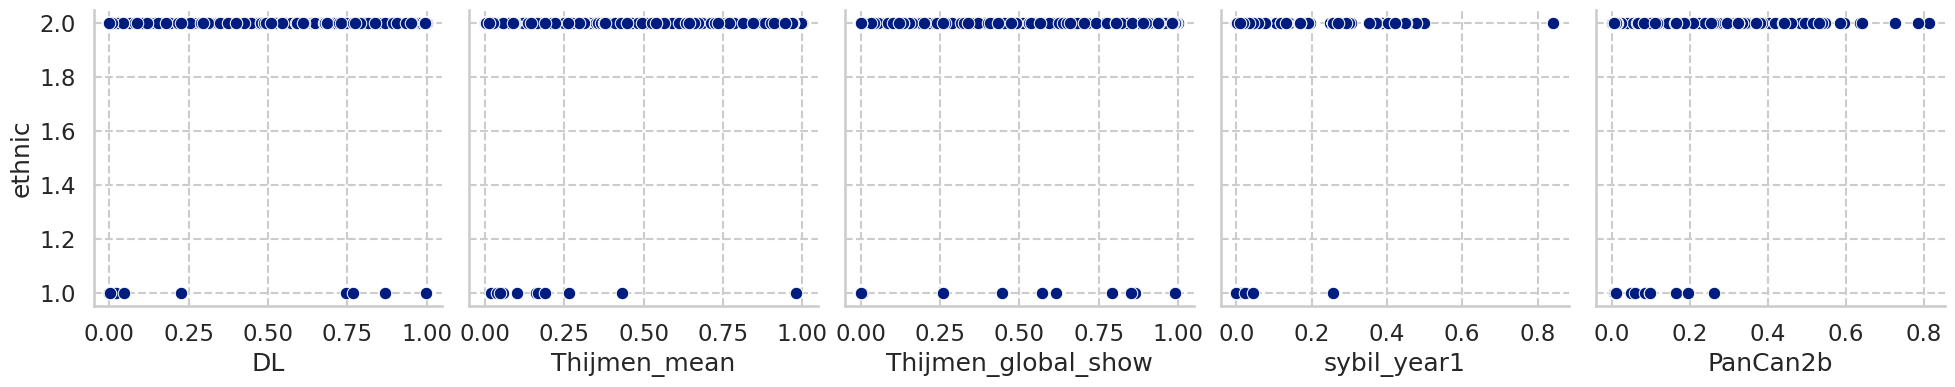

Gender: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.021503,4.620702e-01,0.001978,0.946070,-0.055290,0.059233,0.229614,0.001366
de Haas Combined,0.045055,1.231743e-01,0.000780,0.978726,-0.056485,0.058039,0.219315,0.000493
de Haas Global (shown nodule),-0.002373,9.353297e-01,-0.025388,0.385195,-0.082530,0.031920,0.224090,-0.017308
Sybil,-0.036858,2.073434e-01,0.034353,0.239928,-0.022954,0.091435,0.027766,0.006252
PanCan2b,0.178814,7.055730e-10,0.125031,0.000018,0.068257,0.180997,0.032908,0.027237


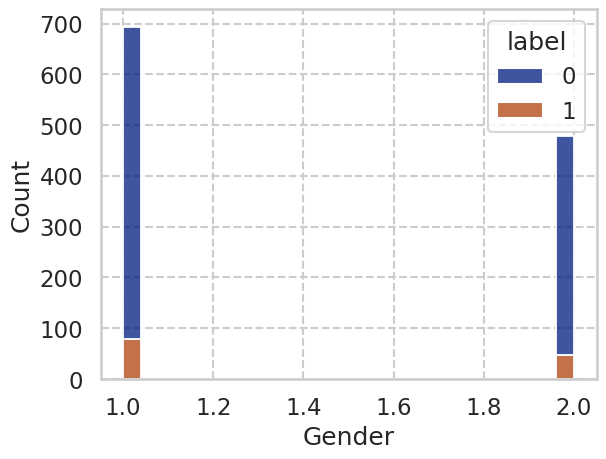

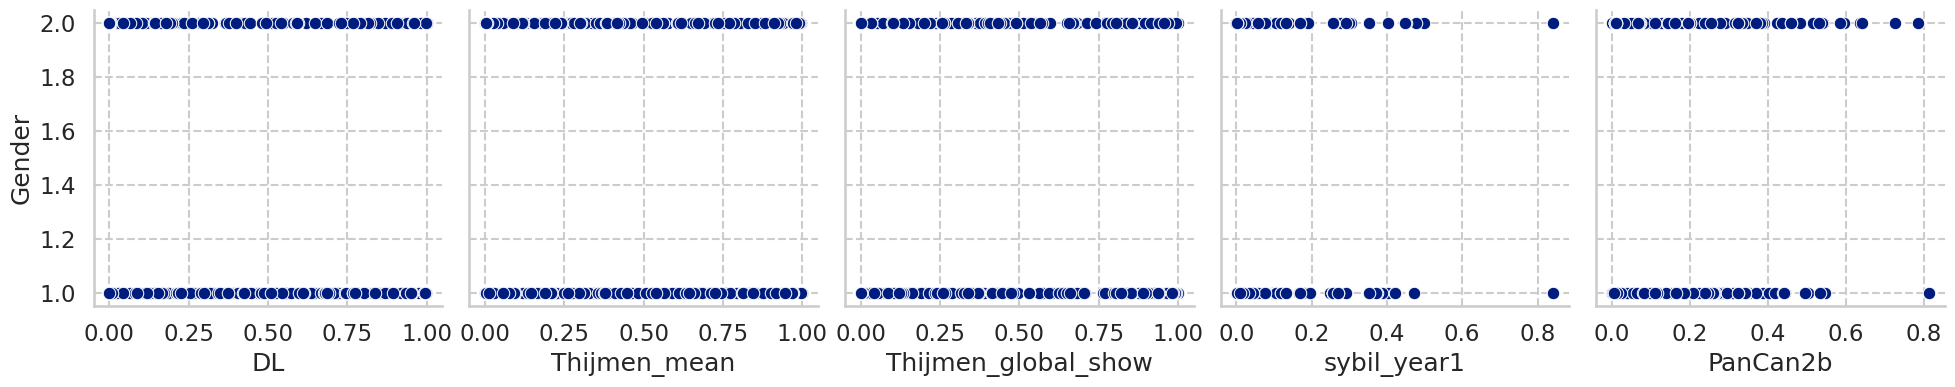

In [56]:
for c in nlst_democols['cat']['demo']:
    print(f"{c}: {nlst_preds[c].isna().sum()} null values")
    display(calc_corr(nlst_preds, c, MODEL_TO_COL))
    sns.histplot(nlst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(nlst_preds, x_vars=MODEL_TO_COL.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()

In [57]:
mlr = LinearRegression()
mlr_df = nlst_preds.dropna(subset=nlst_democols['cat']['demo'], axis=0)
coefs = {}

for m in MODEL_TO_COL:
    mlr.fit(mlr_df[nlst_democols['cat']['demo']], mlr_df[MODEL_TO_COL[m]])
    coefs[m] = mlr.coef_

pd.DataFrame(coefs, index=nlst_democols['cat']['demo']).T

,marital,educat,race,ethnic,Gender
Venkadesh,0.005986,-0.013188,0.048381,-0.223446,-0.009684
de Haas Combined,0.009259,-0.008229,0.016283,-0.025975,-0.010889
de Haas Global (shown nodule),0.010117,-0.014873,0.004325,-0.234344,-0.030386
Sybil,-0.001521,-0.001574,0.007953,-0.007937,0.005319
PanCan2b,0.001980,-0.000588,0.013414,-0.040974,0.023986


### smoking columns

pkyr: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.112744,1.097504e-04,0.135516,0.000003,0.078866,0.191293,0.116922,0.001972
de Haas Combined,0.038392,1.890487e-01,0.076649,0.008662,0.019473,0.133326,0.160694,0.001021
de Haas Global (shown nodule),0.059413,4.199227e-02,0.074613,0.010614,0.017425,0.131314,0.137411,0.001072
Sybil,0.159946,3.685141e-08,0.090275,0.001978,0.033185,0.146779,0.016453,0.000346
PanCan2b,0.068988,1.817372e-02,0.059162,0.042867,0.001907,0.116031,0.055493,0.000272


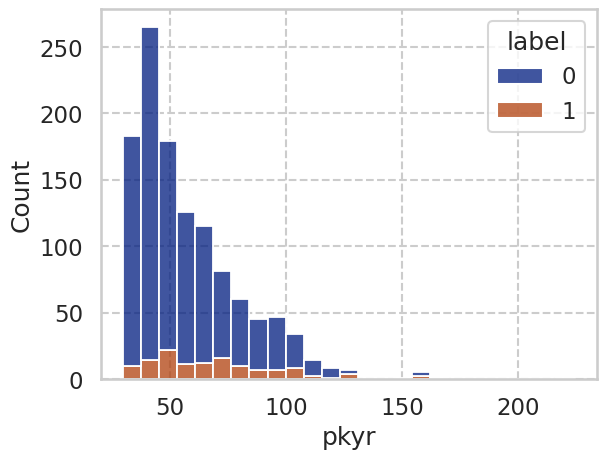

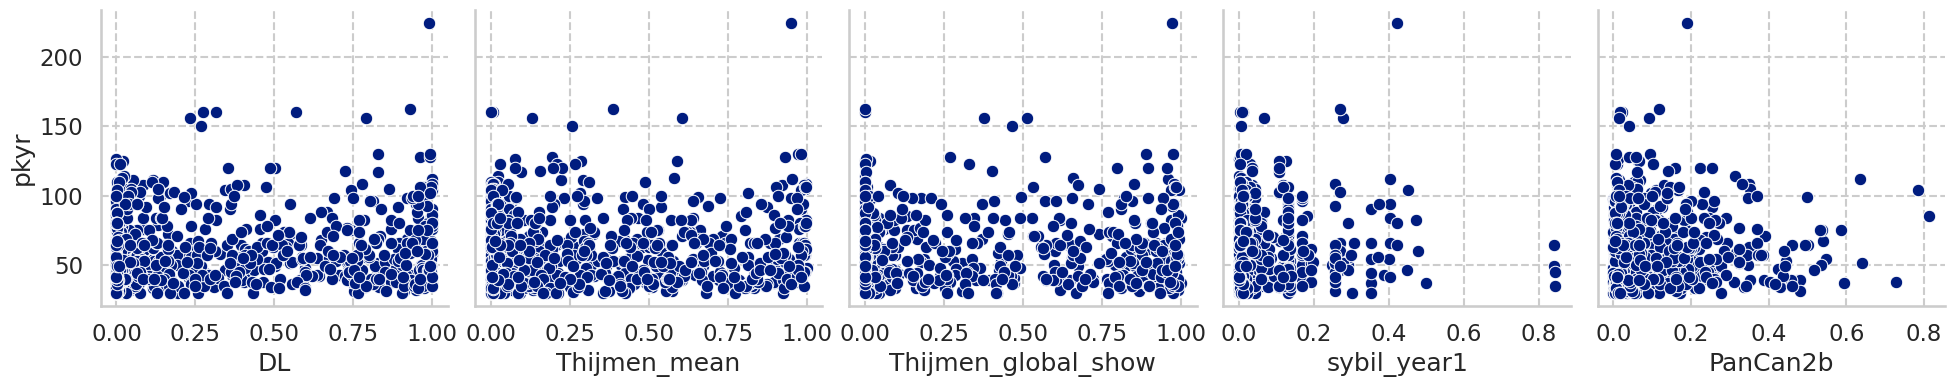

smokeage: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,-0.055584,0.057130,0.002014,0.945098,-0.055255,0.059269,0.228282,0.000198
de Haas Combined,-0.015754,0.590040,0.010062,0.730758,-0.047227,0.067285,0.205122,0.000906
de Haas Global (shown nodule),-0.063339,0.030141,-0.045885,0.116414,-0.102877,0.011407,0.272952,-0.004460
Sybil,-0.059425,0.041951,0.050540,0.083725,-0.006741,0.107491,0.015037,0.001311
PanCan2b,-0.041553,0.155135,-0.021087,0.470789,-0.078254,0.036219,0.082032,-0.000655


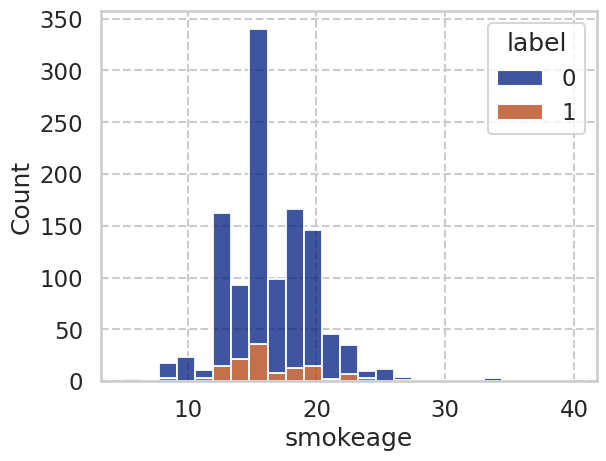

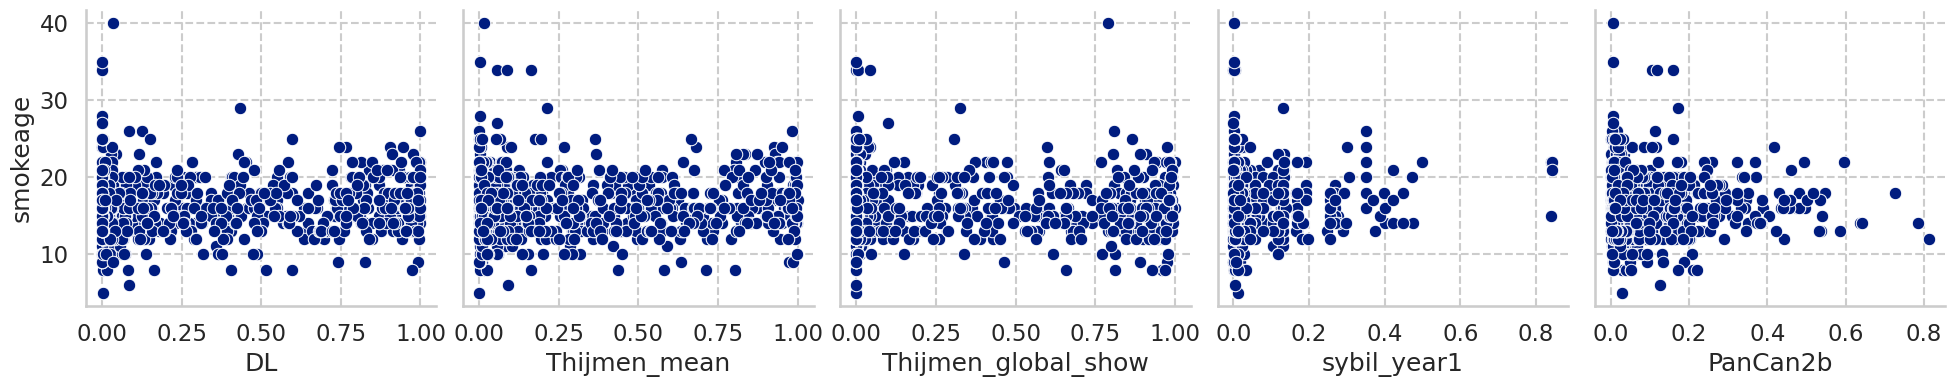

smokeday: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.040962,0.161092,0.058500,0.045251,0.001243,0.115376,0.182157,0.001720
de Haas Combined,-0.014221,0.626708,-0.007097,0.808238,-0.064333,0.050185,0.225490,-0.000191
de Haas Global (shown nodule),0.056866,0.051620,0.026587,0.363143,-0.030721,0.083722,0.177553,0.000772
Sybil,0.084416,0.003828,0.041160,0.159079,-0.016140,0.098190,0.027417,0.000319
PanCan2b,-0.003585,0.902427,-0.013195,0.651792,-0.070404,0.044100,0.074790,-0.000122


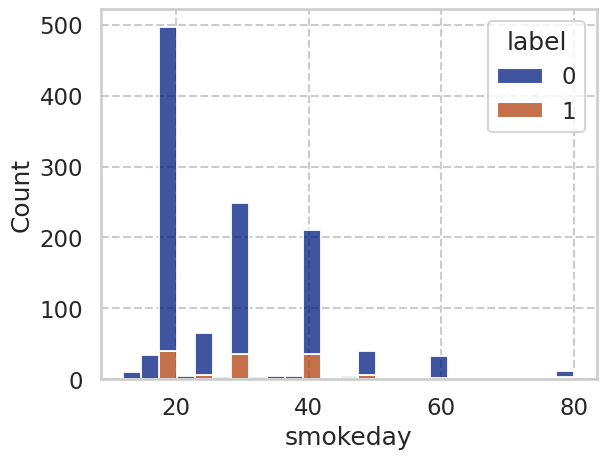

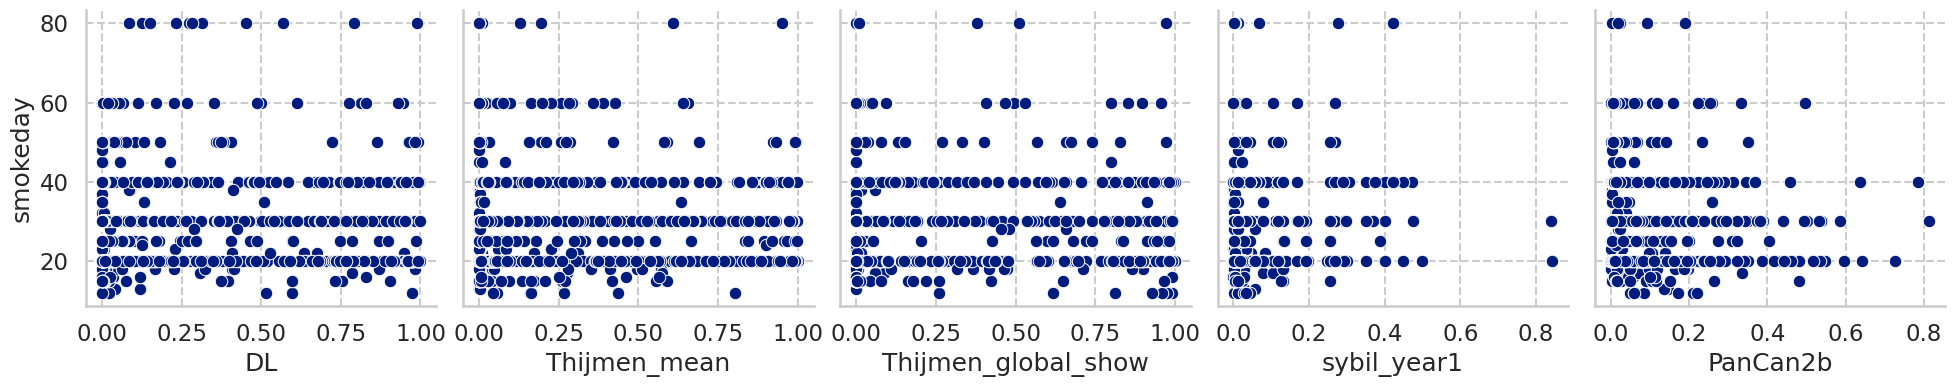

smokeyr: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.117372,5.629865e-05,0.123139,0.000024,0.066345,0.179138,0.007814,0.005426
de Haas Combined,0.107567,2.248778e-04,0.113803,0.000094,0.056912,0.169957,0.030832,0.004588
de Haas Global (shown nodule),0.022103,4.496754e-01,0.060912,0.037071,0.003662,0.117763,0.090460,0.002650
Sybil,0.162033,2.431517e-08,0.055657,0.056801,-0.001610,0.112560,0.009926,0.000646
PanCan2b,0.147425,3.991264e-07,0.132979,0.000005,0.076298,0.188804,-0.004934,0.001848


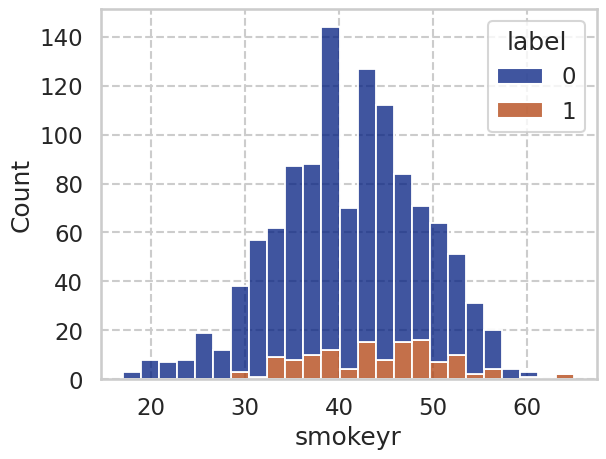

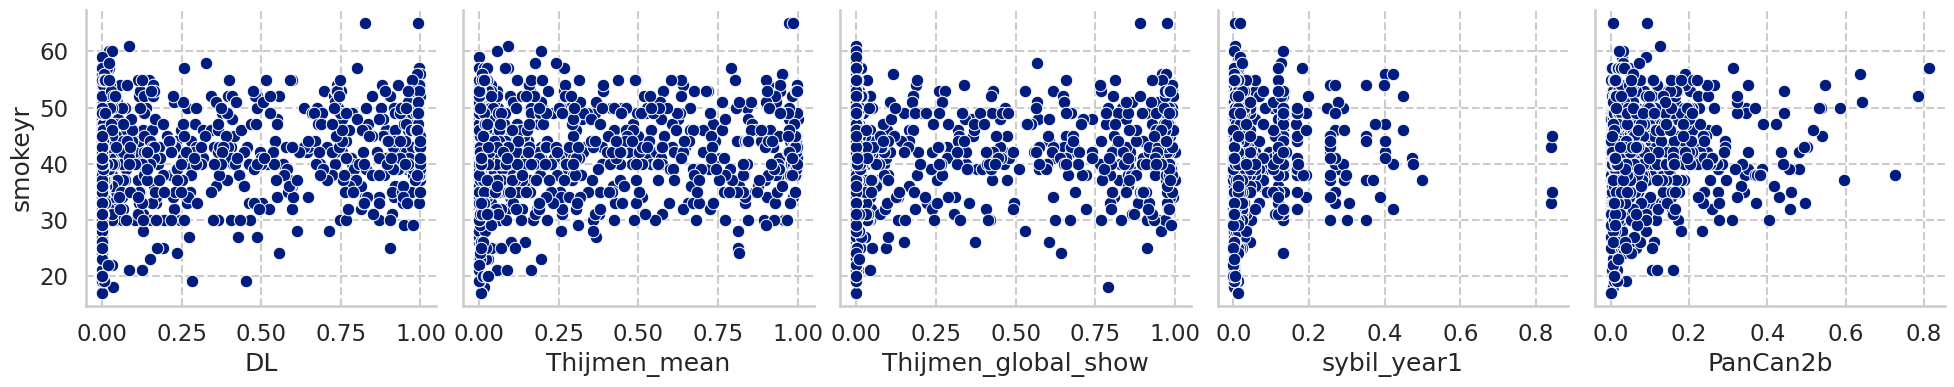

In [58]:
for c in nlst_democols['num']['smoke']:
    print(f"{c}: {nlst_preds[c].isna().sum()} null values")
    display(calc_corr(nlst_preds, c, MODEL_TO_COL))
    sns.histplot(nlst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(nlst_preds, x_vars=MODEL_TO_COL.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()

In [59]:
mlr = LinearRegression()
mlr_df = nlst_preds.dropna(subset=nlst_democols['num']['smoke'], axis=0)
coefs = {}

for m in MODEL_TO_COL:
    mlr.fit(mlr_df[nlst_democols['num']['smoke']], mlr_df[MODEL_TO_COL[m]])
    coefs[m] = mlr.coef_

pd.DataFrame(coefs, index=nlst_democols['num']['smoke']).T

,pkyr,smokeage,smokeday,smokeyr
Venkadesh,0.005015,0.009114,-0.006612,0.000502
de Haas Combined,0.006758,0.008194,-0.012190,-0.004002
de Haas Global (shown nodule),0.004759,-0.000847,-0.007983,-0.004453
Sybil,0.001782,0.002982,-0.002885,-0.001344
PanCan2b,0.000414,0.001565,-0.000557,0.001594


## DLCST: load data

In [60]:
dlcst_preds = pd.read_csv(f"{EXPERIMENT_DIR}/dlcst/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [61]:
MODEL_TO_COL_DLCST = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [62]:
dlcst_democols = ['Age', 'Sex', 'FamilyHistoryLungCa', 'Emphysema', 'NoduleCountPerScan']

## DLCST: How are the columns related with predictions?

Age: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.140446,0.000566,0.247181,8.656852e-10,0.170445,0.320937,-0.719407,0.014823
de Haas,0.135397,0.000893,0.235409,5.489193e-09,0.158282,0.309680,-0.505021,0.011492
Sybil,0.182346,0.000007,0.200870,7.176448e-07,0.122734,0.276531,-0.165130,0.003272
PanCan2b,0.141642,0.000507,0.236092,4.944109e-09,0.158988,0.310334,-0.275032,0.005667


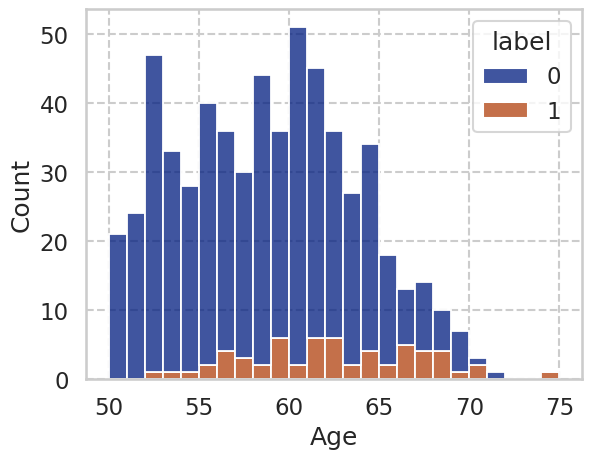

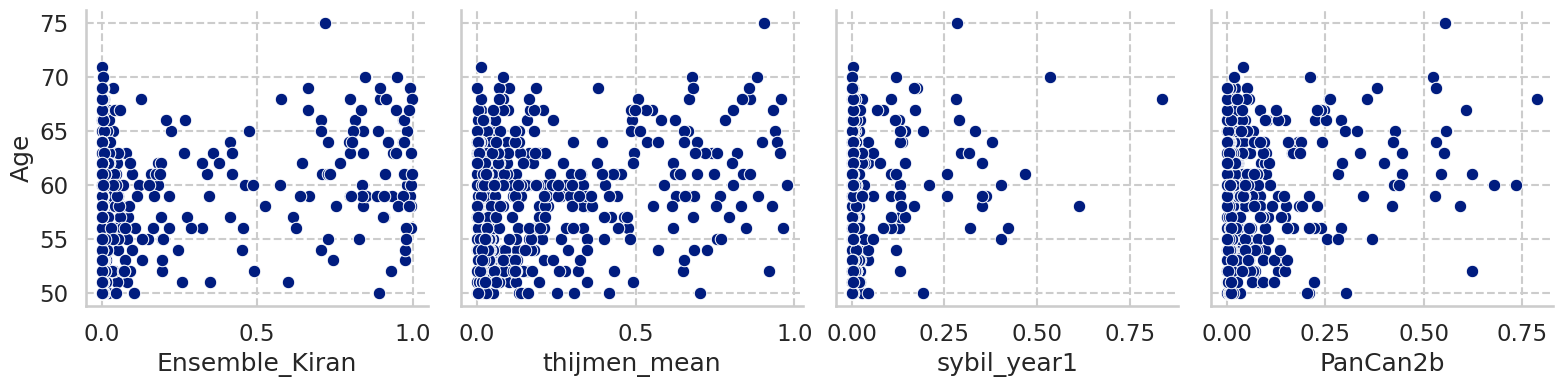

Sex: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.116156,4.419345e-03,0.053005,0.195157,-0.027222,0.132553,0.100164,0.031514
de Haas,0.073525,7.215157e-02,0.025611,0.531572,-0.054612,0.105506,0.147987,0.012396
Sybil,0.045113,2.703037e-01,0.009073,0.824633,-0.071090,0.089119,0.023824,0.001465
PanCan2b,0.203127,5.347889e-07,0.104967,0.010148,0.025067,0.183535,0.019412,0.024980


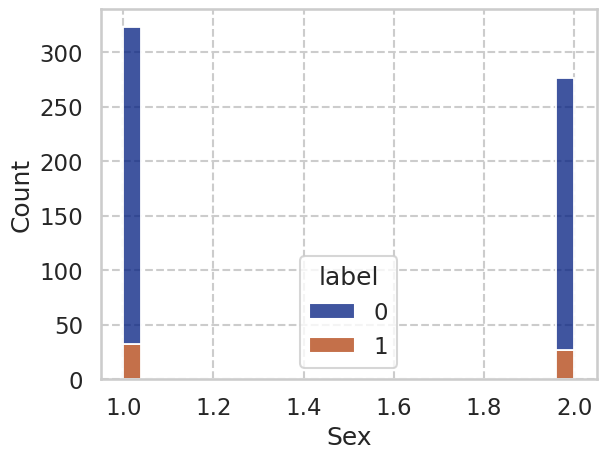

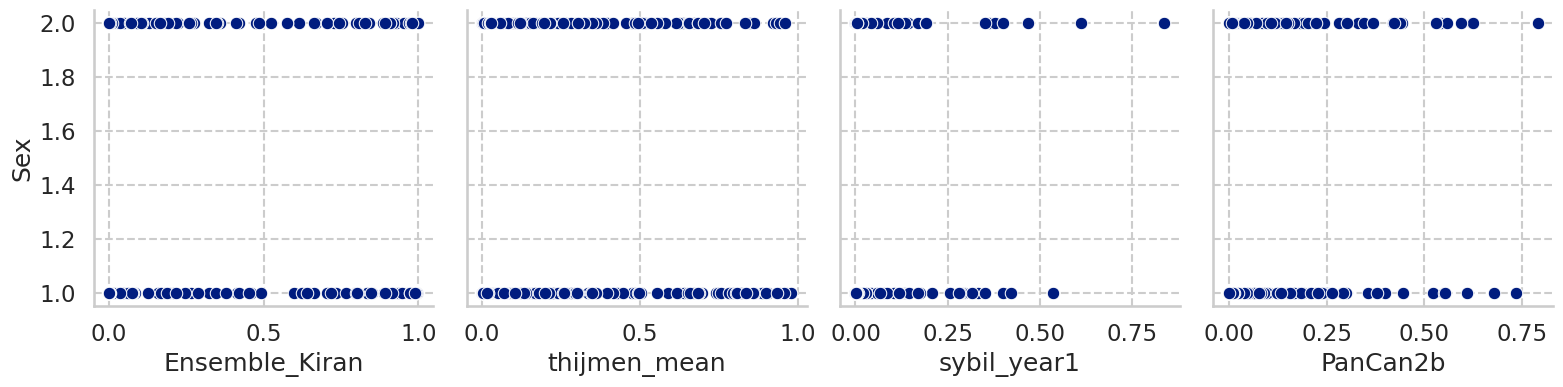

FamilyHistoryLungCa: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.051217,0.210678,0.082711,0.043017,0.002617,0.161750,0.135094,0.065212
de Haas,0.043203,0.291128,0.072589,0.075863,-0.007566,0.151817,0.158161,0.046591
Sybil,0.046076,0.260194,0.097491,0.016998,0.017517,0.176226,0.022409,0.020881
PanCan2b,0.074178,0.069652,0.104386,0.010574,0.024480,0.182968,0.050292,0.032943


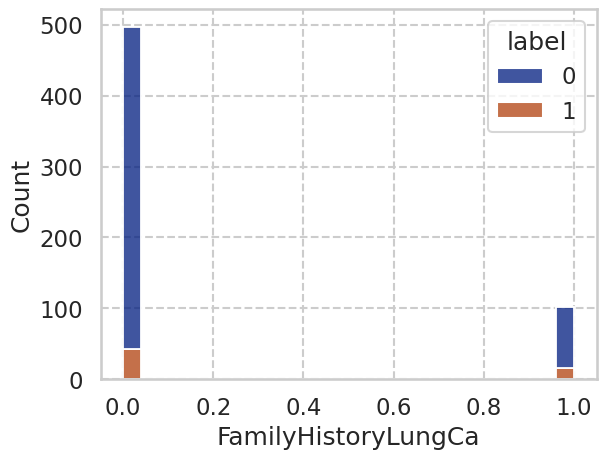

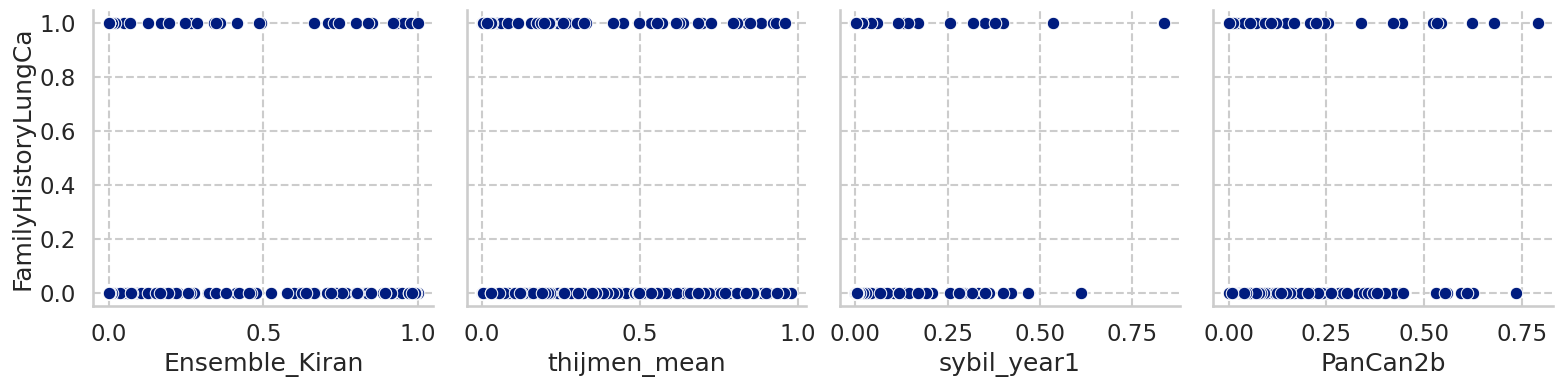

Emphysema: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.117859,0.003870,0.126122,0.001984,0.046480,0.204170,0.092194,0.079873
de Haas,0.130001,0.001430,0.130667,0.001350,0.051091,0.208595,0.120546,0.067367
Sybil,0.165624,0.000046,0.090251,0.027193,0.010214,0.169139,0.015467,0.015527
PanCan2b,0.127563,0.001758,0.120324,0.003184,0.040604,0.198521,0.035279,0.030501


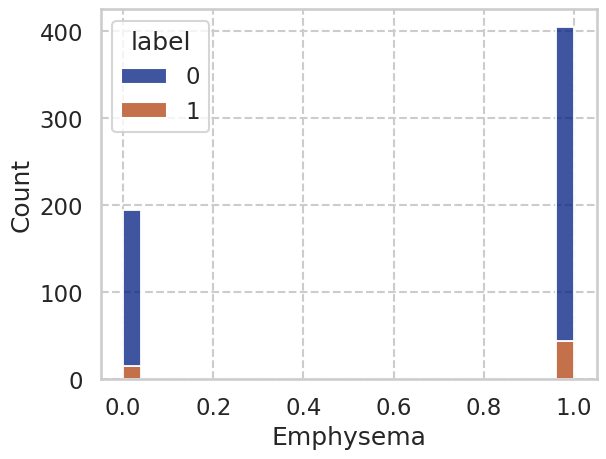

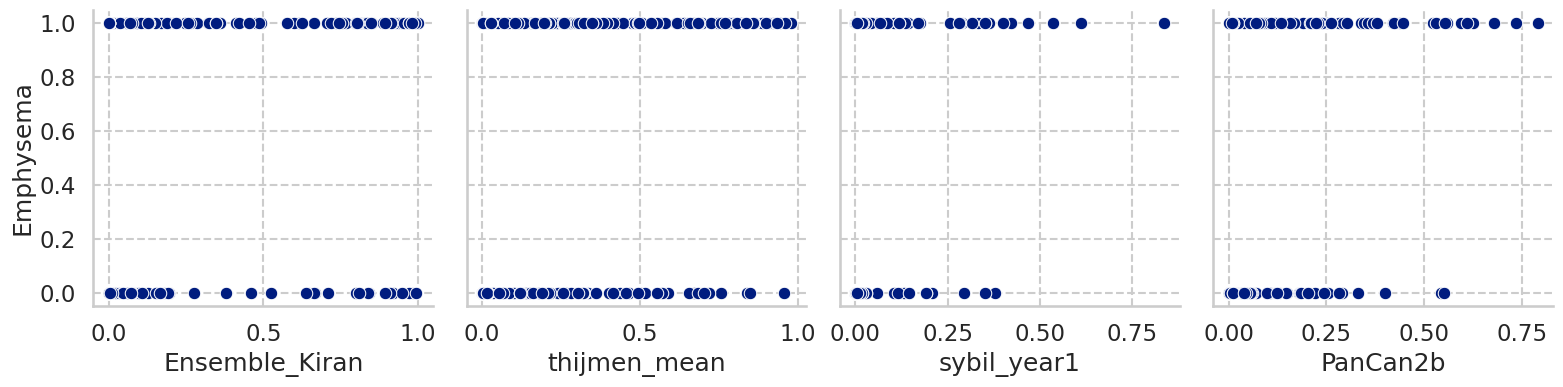

NoduleCountPerScan: 0 null values


,SRC,SRC p-val,PCC,PCC p-val,PCC CI-lo,PCC CI-hi,SLR intercept,SLR coefficient
Venkadesh,0.153208,0.000167,-0.020460,0.617247,-0.100407,0.059749,0.155413,-0.005207
de Haas,0.026541,0.516766,-0.061364,0.133578,-0.140784,0.018839,0.188593,-0.012714
Sybil,0.120600,0.003114,-0.052081,0.203066,-0.131643,0.028147,0.032337,-0.003601
PanCan2b,0.025108,0.539667,-0.058249,0.154488,-0.137718,0.021964,0.066402,-0.005934


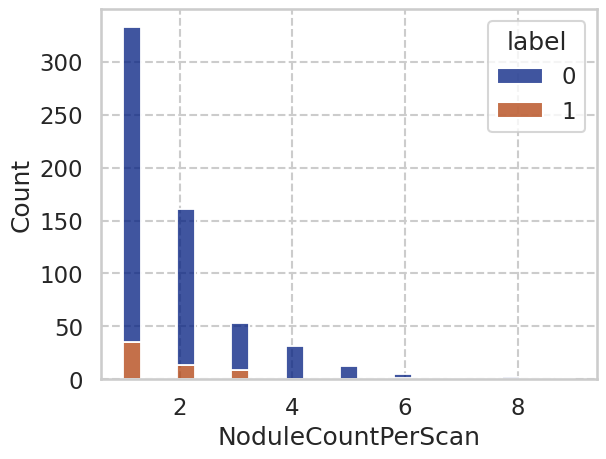

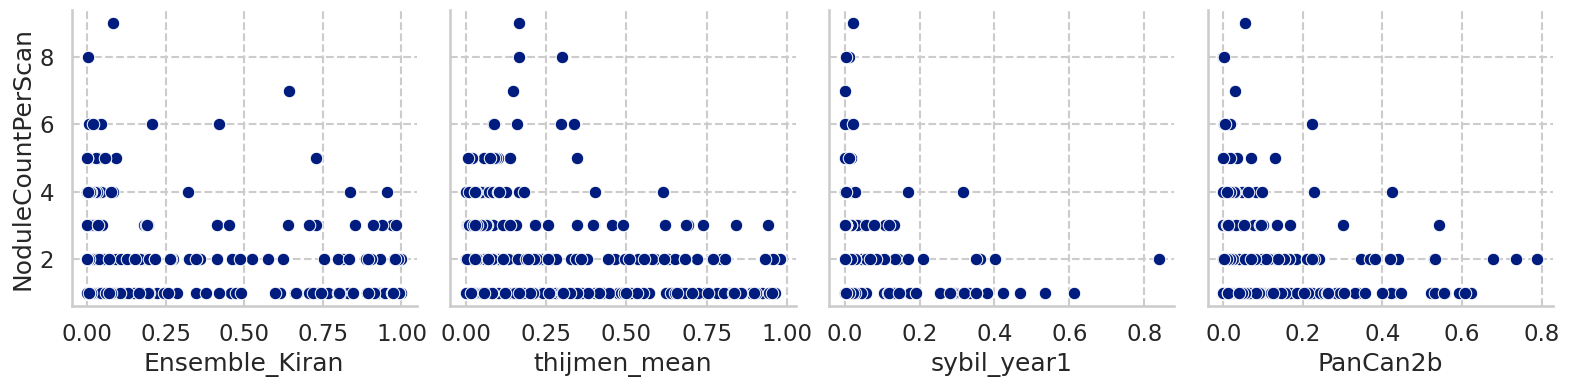

In [63]:
for c in dlcst_democols:
    print(f"{c}: {dlcst_preds[c].isna().sum()} null values")
    display(calc_corr(dlcst_preds, c, MODEL_TO_COL_DLCST))
    sns.histplot(dlcst_preds, x=c, bins=25, hue="label", multiple='stack')
    sns.pairplot(dlcst_preds, x_vars=MODEL_TO_COL_DLCST.values(), y_vars=c, kind='scatter', height=4, aspect=1)
    plt.show()

In [64]:
mlr = LinearRegression()
mlr_df = dlcst_preds.dropna(subset=dlcst_democols, axis=0)
coefs = {}

for m in MODEL_TO_COL_DLCST:
    mlr.fit(mlr_df[dlcst_democols], mlr_df[MODEL_TO_COL_DLCST[m]])
    coefs[m] = mlr.coef_

pd.DataFrame(coefs, index=dlcst_democols).T

,Age,Sex,FamilyHistoryLungCa,Emphysema,NoduleCountPerScan
Venkadesh,0.015087,0.049452,0.074468,0.064107,-0.008562
de Haas,0.011490,0.025687,0.055578,0.056419,-0.015697
Sybil,0.003321,0.004652,0.023675,0.012294,-0.004426
PanCan2b,0.005979,0.031406,0.035561,0.025746,-0.007112
